## Dipolar Wakefield Simulation of the LHC Unshielded Bellows with Wakis

This notebook complements example `001` and demonstrates mesh refinement on a critical accelerator component for transverse beam stability: the CERN-LHC unshielded bellows.

This notebook covers:
* Interactive geometry creation using Constructive Solid Geometry (CSG) blocks with `pyvista`
    - Fully parameterized by `r`, `l`, `n_conv`
* Mesh refinement to align the grid with the bellow's convolution edges
* Simulation of **Dipolar X impedance and wake** by shifting the beam's transverse offset

<span style="display: inline-block; width:800px">

| Geometry and Beam  | Wake potential X and Impedance X  |
| --- | --- | 
| 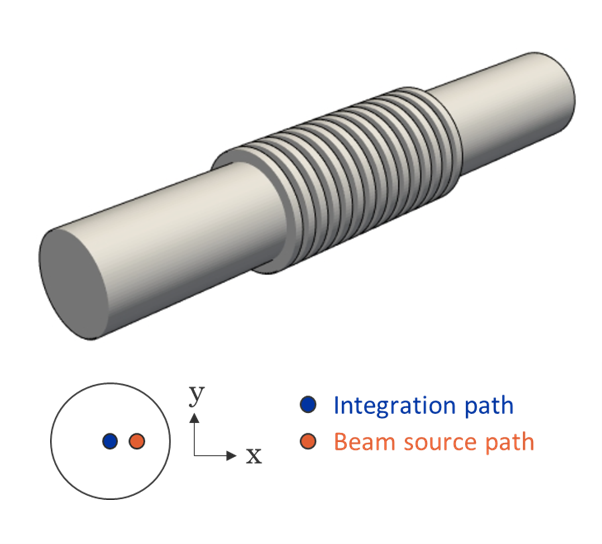  | 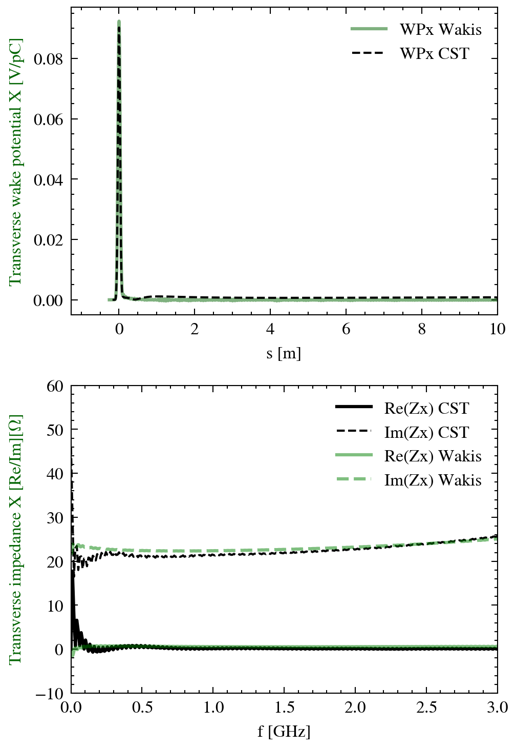 | 

</span>

In [ ]:
# Import required libraries for geometry, visualization, and simulation
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from wakis import SolverFIT3D
from wakis import GridFIT3D
from wakis import WakeSolver

pv.global_theme.window_size = [800, 400]
plot_pyvista = False

### 🏗️ Geometry Generation Using Constructive Solid Geometry (CSG)

We generate the accelerator component geometry in Python using [`PyVista` primitives](https://tutorial.pyvista.org/tutorial/00_intro/a_basic.html#create-basic-geometric-objects), such as cylinders, spheres, cubes, cones, or arbitrary polygons. These can be scaled, translated, rotated, and extruded.

Simple primitives are combined using [boolean operations](https://docs.pyvista.org/examples/01-filter/boolean_operations.html#boolean-operations) such as union (`|`), intersection (`&`), addition (`+`), or difference (`-`), following CSG principles.

This approach allows fully parameterized geometry generation, as shown below:

In [ ]:
# --- Generate beam pipe geometry ---
r_pipe = 24e-3      # Pipe radius in metersml_pipe = 320e-3     # Pipe length in metersth in meters
pipe = pv.Cylinder(center=(0,0,0), direction=(0,0,1), radius=r_pipe, height=l_pipe)

# --- Generate bellow convor_conv = 30e-3   # Convolution radius in metersnl_conv = 4e-3    # Length of each convolution in metersvn_convs = [25, 18, 15]      # List of convolution counts to generatecl_between_conv = 4e-3  # Length between convolutions in metersolutions [m]

# Parametric geometry generation for different n_convs
bellows = []
for n_conv in n_convs:
    print(f'Generating bellow with {n_conv} convolutions...')
    convol    # Calculate starting z position for convolutionsn    z_start = n_conv//2*(l_conv + l_between_conv) - l_convn    for n in range(n_conv):e        z_start_n_conv = -z_start+n*(l_conv+l_between_conv)a        # Create a single convolution as a cylinderi        conv = pv.Cylinder(center=(0,0,z_start_n_conv),d                           direction=(0,0,1),i                           radius=r_conv,a                           height=l_conv)p        convolutions.append(conv)cr    # Combine pipe and convolutions into a single meshr    pipe = pipe.triangulate()c    convolutions = np.sum(convolutions).triangulate()p    bellow = pipe | convolutionse    bellows.append(bellow) p# --- 3D visualization of generated bellows ---
if plot_pyvista:,    pl = pv.Plotter(),    pl.add_mesh(bellows[0], color='r', label=f'{n_convs[0]} convolutions'),    pl.add_mesh(bellows[1].translate((0,-0.1,0)), color='b', label=f'{n_convs[1]} convolutions')
    pl.add_mesh(bellows[2].translate((0,0.1,0)), color='g', label=f'{n_convs[2]} convolutions')
    pl.show()')
pl.show()

We can save the geometry to an `.STL` file for import into Wakis as follows:

In [ ]:
# Save the last bellow (with 15 convolutions) to an STL file
stl_file = 'data/001c_LHC_Bellow_generated.stl'
bellows[2].save(stl_file)  # Save in meters
# To save in millimeters, use: bellow.scale(1e3).save(stl_file)

### 🧱 Domain Setup and Grid Generation

Once the geometry is saved in STL format, we use it as input to generate the grid object with `GridFIT3D`.

This example uses a [mesh refinement algorithm](https://journals.riverpublishers.com/index.php/ACES/article/download/21301/19241?inline=1#S3.F10) for hexahedral cells based on "snappy" lines. This method places grid lines at each convolution edge, achieving better convergence with fewer computational cells.

In [ ]:
#%%px
# ---------- Domain setup ---------
# STL geometry and material assignment
stl_file = 'data/001c_LHC_Bellow_generated.stl'
stl_solids = {'bellow': stl_file}
stl_materials = {'bellow': 'vacuum'}

# Extract domain bounds from STL geometry
bellow = pv.read(stl_file)
xmin, xmax, ymin, ymax, zmin, zmax = bellow.bounds

# Mesh resolution (number of cells in each direction)
Nx = 60
Ny = 60
Nz = 200
print(f'Total number of mesh cells: {Nx*Ny*Nz}')

# Create grid with mesh refinement at STL edges
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz,
                stl_solids=stl_solids,
                stl_materials=stl_materials,
                use_mesh_refinement=True,
                use_mpi=False,
                refinement_tol=1e-8,
                verbose=2)

In [ ]:
# [OPTIONAL] Save grid to HDF5 file for reuse in future simulations
grid.save_to_h5(f'001c_grid_Nx{Nx}Ny{Ny}Nz{Nz}.h5')

In [ ]:
# [OPTIONAL] Load grid from HDF5 file instead of regenerating

# Modify previously ceated grid object
# grid.load_from_h5('data/006_bellow_grid.h5')

# Or generate a new grid object
grid = GridFIT3D(load_from_h5='001c_grid_Nx60Ny60Nz200.h5', verbose=2)

#### 🔎 Extra: Advanced Mesh Diagnostics
This section demonstrates how to analyze mesh refinement snap points, mesh quality, and material property allocation per solid using built-in functions:
* `grid.plot_snap_points()` — Visualize mesh refinement snap points
* `grid.inspect()` — Interactively inspect the grid
* `grid.plot_stl_mask(stl_solid='solid1')` — Overlay STL mask on the grid

In [ ]:
# [OPTIONAL] Plot mesh refinement snap points for diagnostics
if plot_pyvista:
    grid.plot_snap_points()

In [ ]:
# [OPTIONAL] Interactively inspect grid structure and properties
if plot_pyvista:
    grid.inspect()

In [ ]:
# [OPTIONAL] Visualize STL mask overlay on the grid for the 'bellow' solid
if plot_pyvista:
    grid.plot_stl_mask(stl_solid='bellow', stl_opacity=0.2, ymax=0)

### 🏄 Wakefield Settings

The simulation beam source and wakelength are configured in the `WakeSolver` class, 
which is passed to the `SolverFIT3D` for running a wakefield simulation.

In this simulation, the calculation of a **transverse dipolar X wakefield** is shown. 
To simulate dipolar wakefields, the beam source needs to be offset with respect to the 
integration path in the horizontal (x) direction only. 

> Having at least 3 computational cells between the integration and beam axis is recommended.

In [ ]:
#%%px
# ------------ Beam source & Wake solver ----------------

# Beam parameters
sigmaz = 30e-3  # RMS bunch length [m]
q = 1e-9  # Bunch charge [C]
beta = 1.0  # Relativistic beta (v/c)
xs = 8e-3  # x position of beam source [m] (transverse offset)
ys = 0.0  # y position of beam source [m]
xt = 0.0  # x position of test particle [m]
yt = 0.0  # y position of test particle [m]
# tinj = 8.53 * sigmaz / c_light  # Optional: injection time offset [s]

# Wakefield solver setup
wakelength = 10.0  # Propagation length for wake calculation [m]
skip_cells = 30  # Cells to skip near boundary (>= PML cells)
results_folder = "001c_results/"

wake = WakeSolver(
    q=q,
    sigmaz=sigmaz,
    beta=beta,
    xsource=xs,
    ysource=ys,
    xtest=xt,
    ytest=yt,
    skip_cells=skip_cells,
    wakelength=wakelength,
    results_folder=results_folder,
    Ez_file=results_folder+"Ez.h5", # [OPTIONAL] specify field file
)

### ⚡🧲 Setting up the EM Solver:

In [ ]:
#%%px
# Boundary conditions for each axis: ['x', 'y', 'z']
bc_low = ['pec', 'pec', 'pml']   # Lower boundaries: x=PEC, y=PEC, z=PML
bc_high = ['pec', 'pec', 'pml']  # Upper boundaries: x=PEC, y=PEC, z=PML

solver = SolverFIT3D(
    grid,            # Simulation grid object
    wake,            # WakeSolver object (beam and wakefield settings)
    bc_low=bc_low,   
    bc_high=bc_high, 
    use_stl=True,    # Use STL geometry for material assignment
    use_gpu=False,   # Use GPU acceleration 
    use_mpi=False,   # Use MPI for parallel computation 
    bg='pec',        # Background material (e.g., 'pec' for perfect electric conductor)
    n_pml=10,        # Number of PML (Perfectly Matched Layer) layers for absorbing boundaries
    dtype=np.float32 # Floating point precision (np.float32 for single, np.float64 for double)
)

In [ ]:
#%%px
# Inspect the material tensor's assignment in the simulation domain
#   permitivity^-1 `ieps` [F/m]
#   permeability^-1 `imu` [N⋅A-2]
#   conductivity `sigma`  [S/m]
solver.sigma.inspect()

In [ ]:
# Inspect the simulation domain and geometry overlay with interactive widgets
if plot_pyvista:
    solver.inspect(add_silhouette=True)

### 🕒 Wakefield simulation run

In [ ]:
#%%px
import os
os.makedirs(results_folder+'001c_img/', exist_ok=True)

plotkw = {
    'title': results_folder+'001c_img/Ez',      # Output path for Ez field images
    'add_patch': 'bellow',                 # Overlay the 'bellow' geometry on plots
    'patch_alpha': 0.5,                    # Transparency for the geometry overlay
    'vmin': -1e4, 'vmax': 1e4,             # Color scale limits for Ez field
    'plane': [int(grid.Nx/2), slice(0, grid.Ny), slice(0, grid.Nz)],  # Plot a central X-plane
}

solver.wakesolve(
    wakelength=wakelength,     # Propagation length for wake calculation [m]
    wake=wake,                 # WakeSolver object with beam and analysis settings
    plot=True,                # Set to True to enable field visualization during the run
    plot_from=1000,            # Start plotting after this time step
    plot_every=50,             # Plot every N time steps
    plot_until=6000,           # Stop plotting after this time step
    **plotkw                   # Additional plotting options
)

### 🎨 Post-processing and plotting of results 
We can post-process the computed results, or load a previously generated results folder:

In [ ]:
# Load previously computed results for analysis
from wakis import WakeSolver
results_folder = '001c_results_uniform/'
wake = WakeSolver(sigmaz=30e-3,
                  xsource=8e-3,
                  results_folder=results_folder,
                  )

wake.load_results()

# Recompute wake potential and impedance (longitudinal and transverse)
# Adjust the number of cells skipped from the boundary during integration
# to avoid boundary artifacts (useful for low impedance devices!)
wake.solve(skip_cells=40)

In [ ]:
# Recompute the longitudinal and transverse impedance
# with a different maximum frequency and number of samples
wake.calc_long_Z(fmax=3e9, samples=2000)
wake.calc_trans_Z(fmax=3e9, samples=2000)

It's done! Now we can plot the results:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib ipympl

# Plot longitudinal wake potential and impedance
fig1, ax = plt.subplots(1,2, figsize=[8,4], dpi=100)
ax[0].plot(wake.s*1e2, wake.WP, c='tab:red', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()
ax[0].set_xlim(xmax=wake.wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Z), c='tab:blue', alpha=0.8, lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Z), ls='--', c='tab:blue', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Z), ls=':', c='tab:blue', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel(r'Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

# Compare with uniform results
results_folder = '001c_results_uniform/'
wake_unif = WakeSolver(sigmaz=30e-3,
                  xsource=8e-3,
                  results_folder=results_folder,
                  )

wake_unif.load_results()
ax[0].plot(wake_unif.s*1e2, wake_unif.WP, c='k', lw=1.5, label='Wakis Uniform', ls='--')
ax[1].plot(wake_unif.f*1e-9, np.abs(wake_unif.Z), c='k', alpha=0.8, lw=2, label='Abs Uniform', ls='--')
ax[1].plot(wake_unif.f*1e-9, np.real(wake_unif.Z), ls='--', c='k', lw=1.5, label='Real Uniform')

fig1.tight_layout()
fig1.savefig(results_folder+'longitudinal.png')
plt.show()

In [ ]:
# Plot transverse x wake potential and impedance
fig2, ax = plt.subplots(1,2, figsize=[8,4], dpi=100)
ax[0].plot(wake.s*1e2, wake.WPx, c='tab:orange', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Transverse wake potential X [V/pC]', color='tab:orange')
ax[0].legend()
ax[0].set_xlim(xmax=wake.wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Zx), c='tab:green', lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Zx), c='tab:green', ls='--', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zx), c='tab:green', ls=':', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel(r'Transverse impedance X [Abs][$\Omega$]', color='tab:green')
ax[1].legend()

# add CST data for comparison
try:
    cst_wake = wake.read_txt('data/001c_CST_dipolar_x_wake.txt')
    cst_impedance = wake.read_txt('data/001c_CST_dipolar_x_impedance.txt')

    ax[0].plot(cst_wake[0], cst_wake[1], c='k', ls='--', lw=1.5, label='CST')
    ax[1].plot(cst_impedance[0], cst_impedance[1], c='k', ls='--', lw=1.5, label='CST')
    ax[1].plot(cst_impedance[0], -cst_impedance[2], c='k', ls='--', lw=1.5)
except FileNotFoundError:
    print('CST data files not found, skipping CST comparison plots.')

fig2.tight_layout()
fig2.savefig(results_folder+'transverse_x.png')
plt.show()

In [ ]:
# Plot transverse y wake potential and impedance
fig3, ax = plt.subplots(1,2, figsize=[8,4], dpi=100)
ax[0].plot(wake.s*1e2, wake.WPy, c='tab:brown', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Transverse wake potential Y [V/pC]', color='tab:brown')
ax[0].legend()
ax[0].set_xlim(xmax=wake.wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Zy), c='tab:pink', lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Zy), c='tab:pink', ls='--', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Zy), c='tab:pink', ls=':', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel(r'Transverse impedance Y [Abs][$\Omega$]', color='tab:pink')
ax[1].legend()

fig3.tight_layout()
fig3.savefig(results_folder+'transverse_y.png')
plt.show()